In [149]:
%reset -f

In [150]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax

import time
from utils import *;

In [151]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, *args):
        t_vec = jnp.array([t])
        return self.mlp(t_vec)

In [181]:
ystar = 2.0 ## target state
T = 1.0
N = 2

data_size = 1
width_size = 4
depth = 2
seed = 3440
key = jax.random.PRNGKey(seed)

control = Func(data_size, width_size, depth, key=key)
# print("Behold the control term: \n----------------------- \n", control)

ts = jnp.linspace(0, T, N)
print("ts", ts)
y0 = jnp.array([1])

print("\nTesting the control term: \n----------------------- \n", control(jnp.array([ts[0]]), y0))

ts [0. 1.]

Testing the control term: 
----------------------- 
 [[-0.06327683  0.01655005 -0.05999434 -0.03409041]]


In [182]:
class NeuralODE(eqx.Module):
    u: Func

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.u = Func(data_size, width_size, depth, key=key)
        # self.u = Func(11, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.u),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=(ts[1] - ts[0])/1000,
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [183]:
model = NeuralODE(data_size, width_size, depth, key=key)
model(ts, y0)

DeviceArray([[1.       ],
             [1.0325807]], dtype=float32, weak_type=True)

In [184]:
def _get_data(ts, *args, key):
    y0 = jax.random.uniform(key, (1,), minval=-0.6, maxval=1)
    yT = jnp.array([ystar])    ## target state
    return jnp.vstack([y0, yT])     ## data_size is 1

def get_data(dataset_size, *args, key):
    ts = jnp.linspace(0, T, N)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [185]:
def dataloader(array, batch_size, *args, key):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jax.random.permutation(key, indices)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield array[batch_perm]
        start = end
        end = start + batch_size

In [186]:
dataset_size = 256
batch_size = 32
data_key, loader_key = jax.random.split(key, 2)

_, ys = get_data(dataset_size, key=data_key)
train_loader = dataloader(ys, batch_size, key=loader_key)

for i, batch in enumerate(train_loader):
    if i < 1: print(batch)

[[[-0.5589571 ]
  [ 2.        ]]

 [[ 0.5199953 ]
  [ 2.        ]]

 [[-0.00660593]
  [ 2.        ]]

 [[-0.4064253 ]
  [ 2.        ]]

 [[ 0.38700294]
  [ 2.        ]]

 [[ 0.42375183]
  [ 2.        ]]

 [[ 0.57775456]
  [ 2.        ]]

 [[-0.12456877]
  [ 2.        ]]

 [[-0.4055838 ]
  [ 2.        ]]

 [[ 0.6944105 ]
  [ 2.        ]]

 [[-0.3185152 ]
  [ 2.        ]]

 [[-0.22884619]
  [ 2.        ]]

 [[ 0.7775795 ]
  [ 2.        ]]

 [[ 0.8481293 ]
  [ 2.        ]]

 [[ 0.08992632]
  [ 2.        ]]

 [[ 0.8857601 ]
  [ 2.        ]]

 [[ 0.6897484 ]
  [ 2.        ]]

 [[ 0.30989227]
  [ 2.        ]]

 [[ 0.5264921 ]
  [ 2.        ]]

 [[ 0.970163  ]
  [ 2.        ]]

 [[ 0.4143997 ]
  [ 2.        ]]

 [[ 0.71766835]
  [ 2.        ]]

 [[ 0.9217262 ]
  [ 2.        ]]

 [[ 0.6059452 ]
  [ 2.        ]]

 [[ 0.43462867]
  [ 2.        ]]

 [[ 0.983744  ]
  [ 2.        ]]

 [[ 0.02446593]
  [ 2.        ]]

 [[ 0.13332805]
  [ 2.        ]]

 [[ 0.81393355]
  [ 2.        ]]

 [[ 0.5139356 

In [187]:
lr = 3e-3
epochs = 500

optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean(0.5 * (yi[-1] - y_pred[-1]) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

step = 0
for epoch in range(epochs):
    for yi in dataloader(ys, batch_size, key=loader_key):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        step += 1
        if (step % 100) == 0 or step == batch_size*epochs-1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 100, Loss: 0.043251827359199524, Computation time: 0.0008420944213867188
Step: 200, Loss: 0.07030525803565979, Computation time: 0.0008449554443359375
Step: 300, Loss: 0.057524096220731735, Computation time: 0.000843048095703125
Step: 400, Loss: 0.09884238243103027, Computation time: 0.000843048095703125
Step: 500, Loss: 0.008309699594974518, Computation time: 0.0008370876312255859
Step: 600, Loss: 0.009632161818444729, Computation time: 0.0008580684661865234
Step: 700, Loss: 9.015993418870494e-05, Computation time: 0.000843048095703125
Step: 800, Loss: 0.0349203459918499, Computation time: 0.0008370876312255859
Step: 900, Loss: 0.07034989446401596, Computation time: 0.0008459091186523438
Step: 1000, Loss: 0.057522352784872055, Computation time: 0.0008409023284912109
Step: 1100, Loss: 0.09885498136281967, Computation time: 0.0008497238159179688
Step: 1200, Loss: 0.008310830220580101, Computation time: 0.0008358955383300781
Step: 1300, Loss: 0.009632664732635021, Computation time:

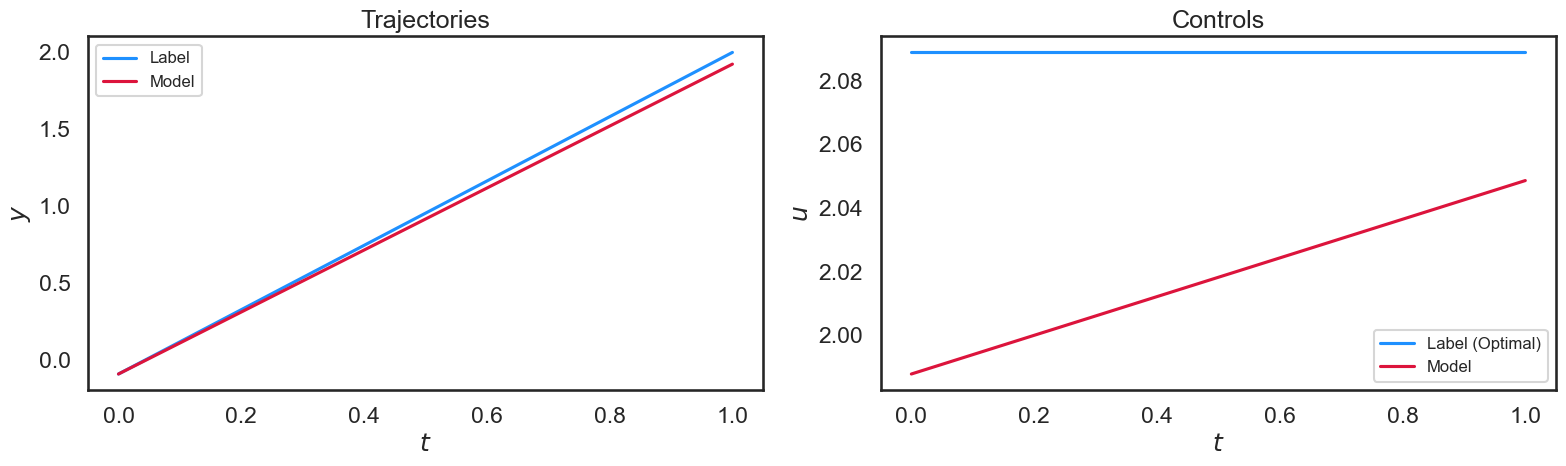

In [202]:
test_key = jax.random.PRNGKey(int(time.time()))
test_point = int(jax.random.uniform(key=test_key, minval=0, maxval=dataset_size))

ytrue = ys[test_point, :]
ypred = model(ts, ys[test_point, 0])[:]

utrue = jnp.ones_like(ytrue) * (ystar-ytrue[0])/T
upred = [model.u(ts[0], ypred[0]), model.u(ts[1], ypred[1])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 5))
ax1 = plot(ts, ytrue, c="dodgerblue", label="Label", title="Trajectories", x_label=r"$t$", y_label=r"$y$", ax=ax1)
ax1 = plot(ts, ypred, c="crimson", label="Model", ax=ax1)

ax2 = plot(ts, utrue, c="dodgerblue", label="Label (Optimal)", title="Controls", x_label=r"$t$", y_label=r"$u$", ax=ax2)
ax2 = plot(ts, upred, c="crimson", label="Model", ax=ax2)